In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage as sk
from PIL import Image 
import albumentations as albu
from albumentations.pytorch import ToTensor
#------------------------------#------------------------------------------------------
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.manifold import TSNE
#------------------------------#------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import kaiming_normal_, constant_
import torchvision
from torchvision import models, transforms
#------------------------------#------------------------------------------------------
from IPython.display import display
import copy
import os
import time
import sys
import re 
import random
#------------------------------#------------------------------------------------------
from utils import *
from dataset import *
from models import FlowNetS, Unsupervised
#------------------------------#------------------------------------------------------
np.random.seed(seed=1)
%matplotlib inline

In [ ]:
flow = readflo('../FlyingChairs_release/data/00008_flow.flo')
dah = computeImg(flow, verbose=True, savePath='result/FlowNetS/predicted_flow8_.png')

### Data augmentation

In [ ]:
frame1 = cv2.cvtColor(cv2.imread('../sintel/training/albedo/alley_1/frame_0010.png'), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread('../sintel/training/albedo/alley_1/frame_0011.png'), cv2.COLOR_BGR2RGB)
flow = readflo('../sintel/training/flow/alley_1/frame_0010.flo')

#########################################################################

f, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(frame1)
ax[0].set_title('frame1')
ax[0].axis("off")
ax[1].imshow(frame2)
ax[1].set_title('frame2')
ax[1].axis("off")
ax[2].imshow(computeImg(flow))
ax[2].set_title('flow')
ax[2].axis("off")

#########################################################################

images = [frame1, frame2]

def create_transformer(transformations, images):
    target = {}
    for i, image in enumerate(images[1:]):
        target['image' + str(i)] = 'image'
    return albu.Compose(transformations, p=1, additional_targets=target)(image=images[0],
                                                                        image0=images[1])

transformed = create_transformer([albu.Blur(p=1)], images)

im1 = transformed['image']
im2 = transformed['image0']
# aug_flow = transformed['image1']
aug_flow = flow
print(im1.shape)
##########################################################################

f, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(im1)
ax[0].set_title('aug_frame1')
ax[0].axis("off")
ax[1].imshow(im2)
ax[1].set_title('aug_frame2')
ax[1].axis("off")
ax[2].imshow(computerArrows(flow = flow, img = frame1), cmap = 'gray')
ax[2].set_title('aug_flow')
ax[2].axis("off")

### Data augmentation. testing with Dataset class

In [2]:
root = '../ChairsSDHom/data'

In [20]:
co_aug_transforms=None
frames_aug_transforms = None
frames_transforms = None

frames_transforms = albu.Compose([
            albu.Normalize((0., 0., 0.), (1., 1., 1.)),
            ToTensor()
        ]) 

co_aug_transforms= albu.Compose([
            albu.RandomSizedCrop((150, 384), 384, 512, w2h_ratio=512/384, p=0.5),
            albu.Flip(),
            albu.ShiftScaleRotate()
        ]) 

frames_aug_transforms= albu.Compose([
            albu.OneOf([albu.Blur(), albu.MedianBlur(), albu.MotionBlur()], p= 0.5),
    
            albu.OneOf([albu.OneOf([albu.HueSaturationValue(), albu.RandomContrast(), 
                        albu.RandomBrightness(),albu.RandomBrightnessContrast()], p= 1),
                        
                        albu.OneOf([albu.CLAHE(), albu.ToGray()], p=1)], p=0.5),
            albu.GaussNoise(),
        ]) 

In [21]:
train, val, test = getDataloaders(2, root, frames_transforms, frames_aug_transforms,
                   co_aug_transforms)

In [25]:
frames,flow = next(iter(train))
frames = frames[0]
flow = flow[0]

In [26]:
frame1_t = frames[:3].numpy().transpose(1, 2, 0)
frame2_t = frames[3:].numpy().transpose(1, 2, 0)
flow_t = flow.numpy().transpose(1, 2, 0)

(-0.5, 511.5, 383.5, -0.5)

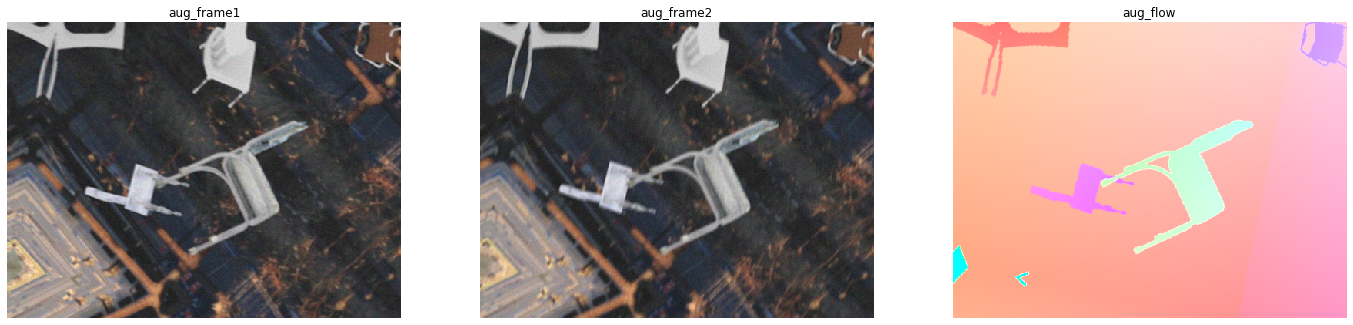

In [27]:
f, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(frame1_t)
ax[0].set_title('aug_frame1')
ax[0].axis("off")
ax[1].imshow(frame2_t)
ax[1].set_title('aug_frame2')
ax[1].axis("off")
ax[2].imshow(computeImg(flow_t))
ax[2].set_title('aug_flow')
ax[2].axis("off")